# A Linear Programming Model for Optimal Transport 

<div class="alert alert-block alert-success">
$\newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} \newcommand{\N}{\mathbb{N}} 
\newcommand{\bff}{\mathbf{f}} \newcommand{\bx}{\mathbf{x}} 
\newcommand{\by}{\mathbf{y}} \newcommand{\bo}{\mathbb{1}} \newcommand{\bJ}{\mathbf{J}}$
In this notebook, we will aim to solve the following optimal transport problem in its linear form:
\begin{align}
\min c^\top x,
\end{align}
subject to
\begin{align}
    \begin{pmatrix} \mathbb{1}_N^\top \otimes I_M \\ I_N \otimes \mathbb{1}_M^\top \end{pmatrix} x &= 
    \begin{pmatrix} m \\ n \end{pmatrix},
    \\
    x &\geq 0;
\end{align}
where $x\in \R^{M\times N}$, $m \in \R^M$, $n \in \R^N$, and $c \in \R^{M\times N}$ is a positive cost vector.
</div>

In particular, we will focus on the optimal transport problem generated by the discrete $\R^2$ measures $\mu$ and $\nu$ defined by 
\begin{align*}
    \mu &= \frac{1}{4}(\delta_{(2,3)} + \delta_{(3,2)} + \delta_{(3,0)} + \delta_{(0,-1)})\\
    \nu &= \frac{1}{4}(\delta_{(0,0)}+ \delta_{(0,2)} + \delta_{(2,1)} + \delta_{(4,2)}),
\end{align*}
and the cost function by defined $c(x,y) = |x-y|^{p}$, with $p>0$. Notice that in this case $N = M$.

To implement this, we will first index the points that define each discreate measure. Here we will label $m_1$ the mass associated with $(2,3)$, $m_2$ the mass associated with $(3,2)$, $m_3$ goes with $(3,0)$, and $m_4$ with $(0,-1)$. Similarly, we will define $n_1$ for the mass at $(0,0)$, $n_2$ with $(0,2)$, $n_3$ with $(2,1)$ and $n_4$ with $(4,2)$. Obviously, we have $m = \frac{1}{4}\bo_M$ and $n = \frac{1}{4}\bo_N$.

We will use the same indeces for $c$, for instance $c_{2,3}$ is the $p$ distance between $(3,2)$ and $(2,1)$.

<div class="alert alert-block alert-info">
The following packages are loaded into the environment. 
</div>

In [1]:
import numpy as np
from numpy import asarray, kron, ones, eye, vstack, where
from scipy.optimize import linprog
from numpy.linalg import norm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

<div class="alert alert-block alert-info">
Here we define the following basic objects:
    
1. `N` and `M` are the number of points where the measures of `μ` and `ν` are concentrated,
2. `p` is the distance power,
3. `c` is the vector of costs.
</div>

In [2]:
N = 4
M = 4
μ = asarray([ (2,3), (3,2), (3,0), (0,-1) ])
ν = asarray([ (0,0), (0,2), (2,1), (4,2) ])
p = 4.50374

In [3]:
c = asarray([ norm(a-b, p) for b in ν for a in μ])

<div class="alert alert-block alert-warning">
Optimisation model
</div>

`A` contains the coeficients of the equality constraints:

In [4]:
A = vstack( ( kron(ones([1,N]), eye(M)), kron(eye(N), ones([1,M])) ) )

`b` contains the coeficients of the RHS.

In [5]:
b = 0.25 * vstack( (ones([N,1]), ones([M,1])) )

In [6]:
solution = linprog(c, A_eq = A, b_eq = b, method = 'revised simplex' ) # Bounds are already included by default

/Users/andy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  """Entry point for launching an IPython kernel.


In [7]:
x = solution.x
print(solution)

     con: array([0., 0., 0., 0., 0., 0., 0., 0.])
     fun: 1.2964068613564463
 message: 'Optimization terminated successfully.'
     nit: 10
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.25, 0.  , 0.  ])


Now we can process $x$ such that we recover only its positive entries:

In [8]:
X = where(x.reshape(N,M, order='F'))
S = { (tuple(μ[i]), tuple(ν[j])): x.reshape(N,M, order='F')[i,j] for (i,j) in asarray(X).T }
print(S)

{((2, 3), (0, 2)): 0.25, ((3, 2), (4, 2)): 0.25, ((3, 0), (2, 1)): 0.25, ((0, -1), (0, 0)): 0.25}


At last, we plot the solution.

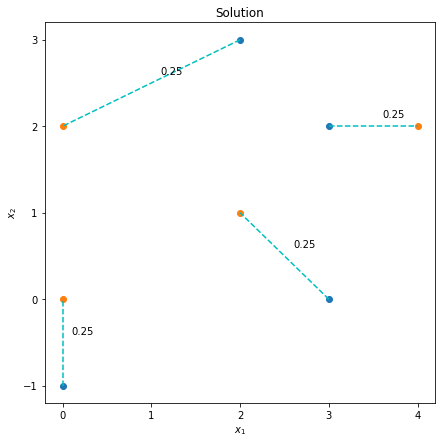

In [9]:
plt.figure(figsize=(7,7))

plt.scatter(μ[:,0], μ[:,1])
plt.scatter(ν[:,0], ν[:,1])
for a in S.keys():
    plt.plot([a[0][0], a[1][0]], [a[0][1], a[1][1]], 'c--')
    plt.annotate(S[a], [0.5*(a[0][0]+a[1][0])+0.1, 0.5*(a[0][1] + a[1][1])+0.1])

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Solution')
plt.show()

# Original form

<div class="alert alert-block alert-success">
We can actually solve the original problem with an LP solver that allows indexing:
\begin{align}
    \min c : \gamma,
\end{align}
subject to
\begin{align}
    \sum_{j} \gamma_{i,j} &= m_i
    \\
    \sum_{i} \gamma_{i,j} &= n_j
    \\
    \gamma_{i,j} &\geq 0.
\end{align}
</div>

In [10]:
from gurobipy import *

In [11]:
N = 4
M = 4
μ = [ (2,3), (3,2), (3,0), (0,-1) ]
ν = [ (0,0), (0,2), (2,1), (4,2) ]
p = 4.50374

In [12]:
c = { (b,a): norm([a[0]-b[0], a[1]-b[1]], p) for a in ν for b in μ}
m = { a: 0.25 for a in μ }
n = { a: 0.25 for a in ν }

In [13]:
mo = Model()
γ  = {}

Using license file /Users/andy/gurobi.lic
Academic license - for non-commercial use only


In [14]:
γ = mo.addVars( μ, ν, vtype = 'C', name ='g', obj = {a[0]+a[1]:b for a,b in c.items()}, lb = 0.0)

In [15]:
mo.update()

In [16]:
mo.addConstrs( (γ.sum(i[0],i[1],'*','*') == m[i] for i in μ), name='m' );
mo.addConstrs( (γ.sum('*','*',j[0],j[1]) == n[j] for j in ν), name='n');
mo.update()

In [17]:
mo.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x71c2068c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e-01]
Presolve time: 0.02s
Presolved: 8 rows, 16 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2915950e+00   5.000000e-01   0.000000e+00      0s
       1    1.2964069e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  1.296406861e+00


We get the same plot as before:

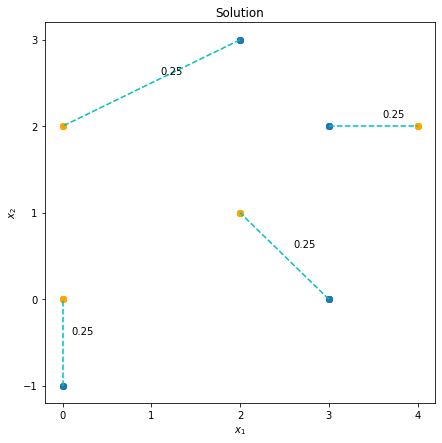

In [18]:
plt.figure(figsize=(7,7))

for a,b in γ.items():
    plt.scatter(a[0], a[1], color='tab:blue')
    plt.scatter(a[2], a[3], color='orange')
    if b.x > 0.0:
        plt.plot([a[0], a[2]], [a[1], a[3]], 'c--')
        plt.annotate(b.x, [0.5*(a[0] + a[2])+0.1, 0.5*(a[1] + a[3])+0.1])
    

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Solution')
plt.show()

Something nice about Gurobi is that we can retrieve the shadow prices:

In [19]:
f = {a: mo.getConstrByName('m[' + str(a[0]) + ',' + str(a[1]) + ']').Pi for a in μ}
g = {a: mo.getConstrByName('n[' + str(a[0]) + ',' + str(a[1]) + ']').Pi for a in ν}

with this information, we check on optimality:

In [20]:
{ (a,b): f[a] + g[b] <= c[a,b] for b in ν for a in μ}

{((2, 3), (0, 0)): True,
 ((3, 2), (0, 0)): True,
 ((3, 0), (0, 0)): True,
 ((0, -1), (0, 0)): True,
 ((2, 3), (0, 2)): True,
 ((3, 2), (0, 2)): True,
 ((3, 0), (0, 2)): True,
 ((0, -1), (0, 2)): True,
 ((2, 3), (2, 1)): True,
 ((3, 2), (2, 1)): True,
 ((3, 0), (2, 1)): True,
 ((0, -1), (2, 1)): True,
 ((2, 3), (4, 2)): True,
 ((3, 2), (4, 2)): True,
 ((3, 0), (4, 2)): True,
 ((0, -1), (4, 2)): True}

Let's print each value just for reference:

In [21]:
print(f)
print(g)

{(2, 3): 2.0, (3, 2): 1.0, (3, 0): 1.1663798360737463, (0, -1): 1.0}
{(0, 0): 0.0, (0, 2): 0.01924760935203862, (2, 1): 0.0, (4, 2): 0.0}
